### Récupération du dataset

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('Mall_Customers.xls',index_col='CustomerID')

display(df)
df.info()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40
...,...,...,...,...
196,Female,35,120,79
197,Female,45,126,28
198,Male,32,126,74


<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


### Gestion des doublons et des valeurs manquantes

In [2]:
# Vérifier l'absence de doublons
print(df.duplicated().sum())

# Vérifier l'absence de valeurs nulles
print(df.isna().sum())

0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


### Vérification de la validité des données

Gender
Female    112
Male       88
Name: count, dtype: int64


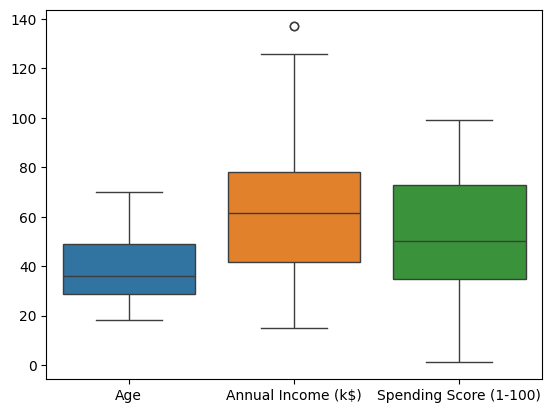

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Vérifier la distribution des données qualitatives
print (df['Gender'].value_counts())

# Vérifier la distribution des données quantitatives
sns.boxplot(df.drop(['Gender'], axis=1))
plt.show()
# Les données semblent cohérentes

### Analyse des relations entre les données

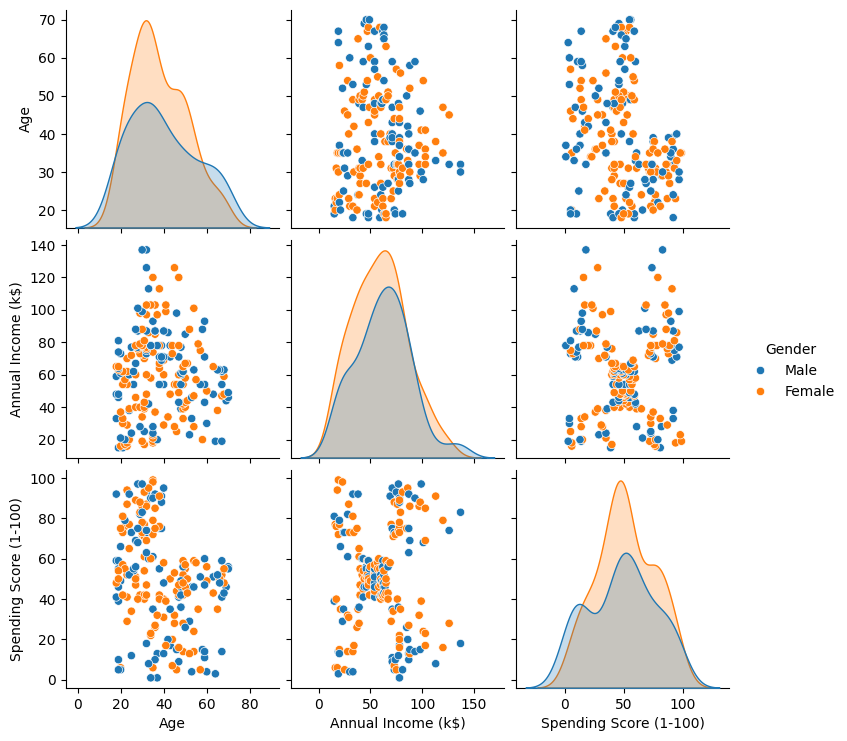

In [4]:
# On trace un pairplot des variables numériques en catégorisant suivant le genre
sns.pairplot(df,hue='Gender')


### Préprocessing

In [5]:
# On fera la clusterisation sur les données numériques uniquement
df_model = df.drop('Gender',axis=1)

# Normalisation
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_model_scaled = scaler.fit_transform(df_model)
df_model = pd.DataFrame(df_model_scaled, columns=df_model.columns)

df_model.head()

,Age,Annual Income (k$),Spending Score (1-100)
0,0.019231,0.000000,0.387755
1,0.057692,0.000000,0.816327
2,0.038462,0.008197,0.051020
3,0.096154,0.008197,0.775510
4,0.250000,0.016393,0.397959


### Entraînement 1er KMeans

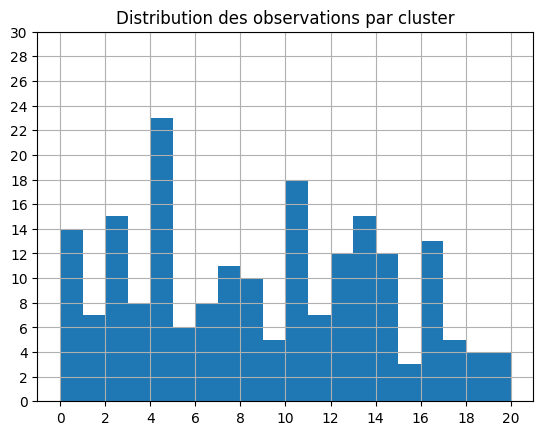

In [11]:
from sklearn.cluster import KMeans

# on va utiliser 200/10 = 20 clusters pour commencer
kmeans1 = KMeans(n_clusters=20)
kmeans1.fit(df_model)

# Calcul des centroïds et des labels
centroidsk1 = kmeans1.cluster_centers_
labelsk1 = kmeans1.labels_

plt.hist(labelsk1,bins=np.arange(0,21))
plt.title("Distribution des observations par cluster")
plt.grid(True)
plt.xticks(np.arange(0,22,2))
plt.yticks(np.arange(0,32,2))
plt.show()

# Les clusters semblent répartis de manière plutôt équilibrée



### Entraînement CAH des centroïdes du 1er KMeans

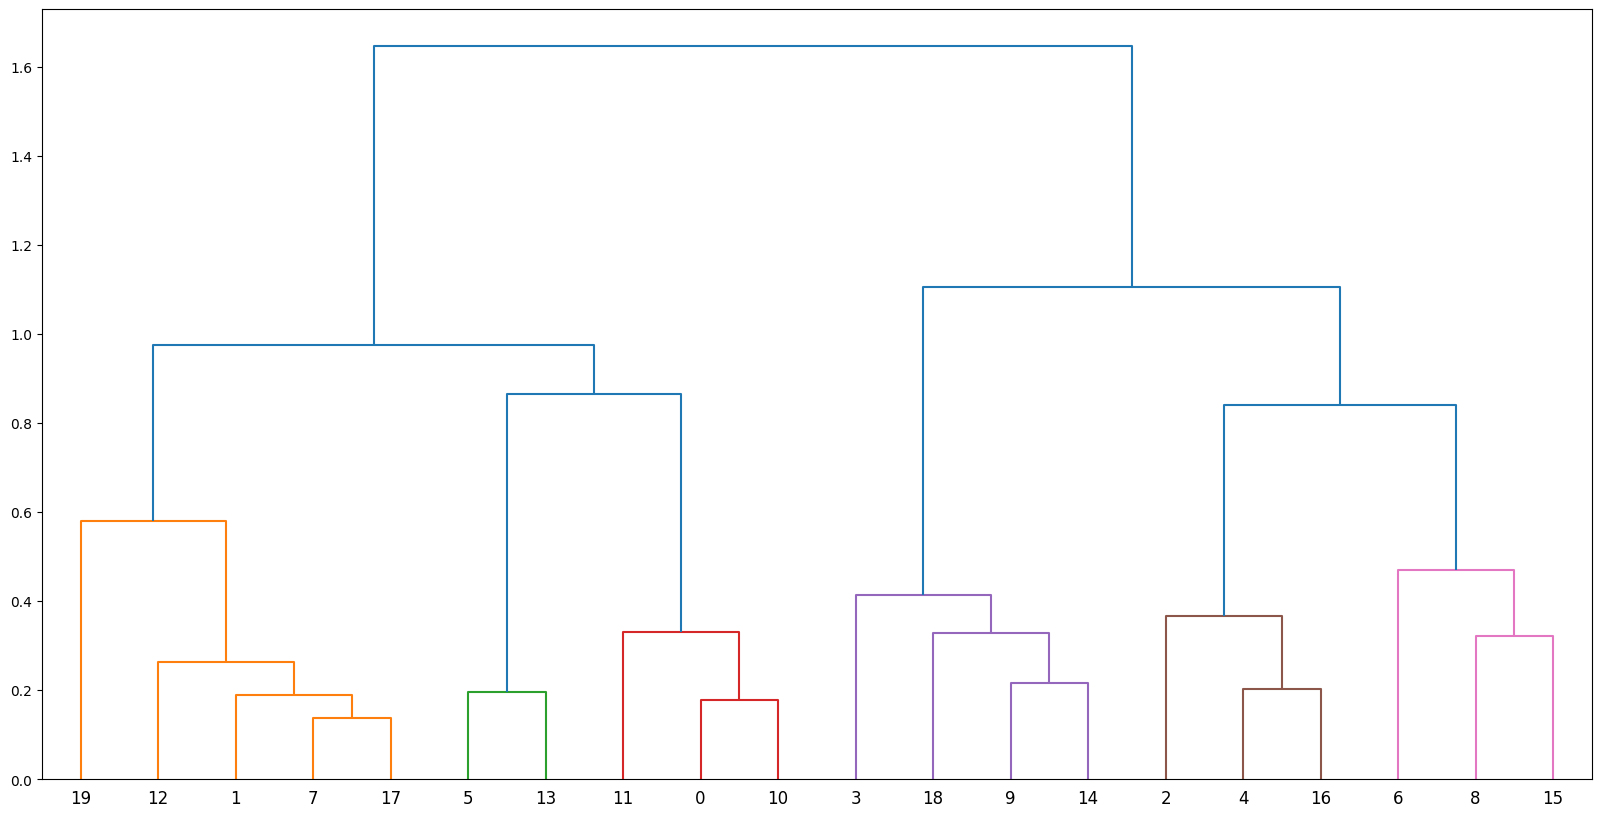

In [13]:
# Dendegramme des 20 centroïdes
from scipy.cluster.hierarchy import linkage,dendrogram
Z = linkage(centroidsk1, method = 'ward', metric = 'euclidean')

plt.figure(figsize=(20,10))
dendrogram(Z,color_threshold=0.8)
plt.show()

# D'après le dendogramme, le nbre de clusters optimal est 6 (les labels oranges d'un côté, le reste de l'autre)

In [15]:
# on va donc utiliser 6 clusters pour les centroïdes de K1

from sklearn.cluster import AgglomerativeClustering
cah = AgglomerativeClustering(6)
cah.fit(centroidsk1)

# Calcul des labels CAH des centroïdes du 1er KMeans
centroidsk1_labelscah = cah.labels_

# A chaque observation on va lui associer ce label CAH
df_model['label_cah'] = [centroidsk1_labelscah[labelk1] for labelk1 in labelsk1]

# Calcul des centroïdes correspondant
centroids_cah = df_model.groupby('label_cah').mean()
display(centroids_cah)

# Suppression de la colonne provisoire cluster_label
df_model = df_model.drop('label_cah',axis=1)

,Age,Annual Income (k$),Spending Score (1-100)
label_cah,,,
0,0.130671,0.336696,0.453166
1,0.529304,0.092506,0.187561
2,0.505968,0.621820,0.166432
3,0.282544,0.586381,0.827839
4,0.130952,0.087041,0.808552
5,0.696833,0.331083,0.484394


### Entraînement 2ème KMeans

In [16]:
# on va utiliser les 6 centroïdes obtenus par KMeans + CAH pour initier le KMeans final
kmeans2 = KMeans(n_clusters=6,init=centroids_cah)
kmeans2.fit(df_model)

# Calcul des centroïds et des labels
centroidsk2 = kmeans2.cluster_centers_
labelsk2 = kmeans2.labels_

### Visualisation des clusters et centroïdes

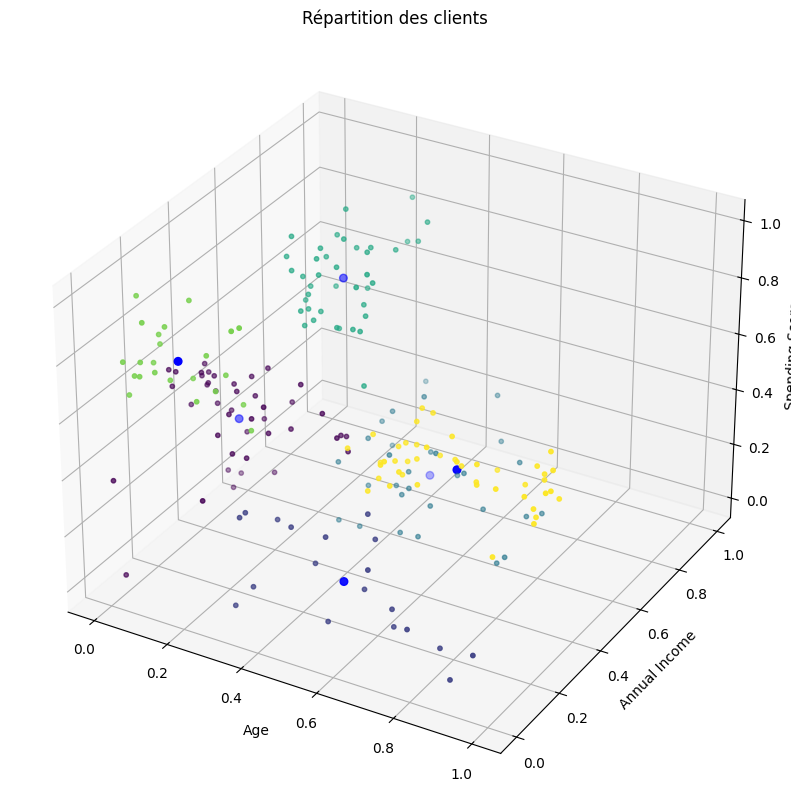

In [20]:
#Visualisation des clusters et des centroïdes 

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(df_model['Age'],df_model['Annual Income (k$)'],df_model['Spending Score (1-100)'],c=labelsk2,s=10)
ax.scatter(centroidsk2[:, 0],centroidsk2[:, 1], centroidsk2[:, 2],marker = "o", color = "blue",s=30)
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income')
ax.set_zlabel('Spending Score')
ax.set_title("Répartition des clients")

plt.show()